In [1]:
# FIX: Downgrade protobuf to a version compatible with TensorFlow
!pip install protobuf==3.20.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 4.4 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.26.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
grain 0.2.15 requires protobuf>=5.28.3, but you have protobuf 3.20.3 which is incompatible.
onnx 1.20.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
ray 2.52.1 requires click!=8.3.*,>=7.0, but you have click 8.3.1 which is incompatible.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have proto

In [3]:
import os
import tensorflow as tf

# Suppress logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

print(f"TensorFlow Version: {tf.__version__}")
print("Checking GPU...")

# Check for GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"SUCCESS: GPU Detected: {tf.test.gpu_device_name()}")
    print("You can now proceed to run the Data Parsing code.")
else:
    print("ERROR: No GPU detected. Make sure Accelerator is set to GPU T4.")

TensorFlow Version: 2.19.0
Checking GPU...
✅ SUCCESS: GPU Detected: /device:GPU:0
You can now proceed to run the Data Parsing code.


I0000 00:00:1767707564.748595      55 gpu_device.cc:2019] Created device /device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1767707564.748812      55 gpu_device.cc:2019] Created device /device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Scanning directory: /kaggle/input/the-oxfordiiit-pet-dataset/images ...
✅ Data Loaded Successfully!
Total Images: 7390
Unique Breeds: 37

Sample Data (First 5 rows):
                 filename           breed
0          samoyed_59.jpg         samoyed
1          beagle_102.jpg          beagle
2  great_pyrenees_126.jpg  great_pyrenees
3  english_setter_170.jpg  english_setter
4            boxer_95.jpg           boxer


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# 1. Split the data
# We use 'stratify' to ensure every breed is represented equally in all sets
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['breed'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['breed'])

print(f"Training Images:   {len(train_df)}")
print(f"Validation Images: {len(val_df)}")
print(f"Test Images:       {len(test_df)}")

# 2. Setup Generators
# MobileNetV2 requires images to be 224x224
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Train Generator (With Data Augmentation)
# This creates new variations of images to make the model smarter
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, # Crucial for MobileNetV2
    rotation_range=20,       # Rotate slightly
    width_shift_range=0.2,   # Shift left/right
    height_shift_range=0.2,  # Shift up/down
    shear_range=0.2,         # Distort shape slightly
    zoom_range=0.2,          # Zoom in/out
    horizontal_flip=True,    # Flip horizontally
    fill_mode='nearest'      # How to fill empty space after rotation
)

# Validation/Test Generator (No Augmentation, just Preprocessing)
val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# 3. Create the Flow
print("\nLoading images from disk...")

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=dataset_path,
    x_col='filename',
    y_col='breed',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=dataset_path,
    x_col='filename',
    y_col='breed',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False 
)

# Important: shuffle=False for Test so predictions match the actual labels order
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=dataset_path,
    x_col='filename',
    y_col='breed',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False 
)

Training Images:   5912
Validation Images: 739
Test Images:       739

Loading images from disk...
Found 5912 validated image filenames belonging to 37 classes.
Found 739 validated image filenames belonging to 37 classes.
Found 739 validated image filenames belonging to 37 classes.


In [6]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# 1. Load the Base Model (Pre-trained on ImageNet)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 2. Freeze the Base Model
base_model.trainable = False

# 3. Add Custom Layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)

# --- FIX START ---
# We calculate the number of classes from the class_indices dictionary
num_classes = len(train_generator.class_indices)
predictions = Dense(num_classes, activation='softmax')(x)
# --- FIX END ---

# 4. Construct Final Model
model = Model(inputs=base_model.input, outputs=predictions)

# 5. Compile
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

print("Model Built Successfully!")
print(f"Number of output classes: {num_classes}")
model.summary()

I0000 00:00:1767707605.786325      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1767707605.786561      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✅ Model Built Successfully!
Number of output classes: 37


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,607,653 (13.76 MB)

 Trainable params: 1,349,669 (5.15 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [7]:
from tensorflow.keras.callbacks import EarlyStopping

# Stop training if validation loss doesn't improve for 3 consecutive epochs
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True,
    verbose=1
)

print("Starting Training...(This may take a few minutes)")

# Train the model
history = model.fit(
    train_generator,
    epochs=15,             # Maximum number of epochs
    validation_data=val_generator,
    callbacks=[early_stop]
)

print("Training Completed.")

🚀 Starting Training... (This may take a few minutes)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


I0000 00:00:1767707654.284255     131 service.cc:152] XLA service 0x78109c1433c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767707654.284295     131 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1767707654.284302     131 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1767707655.323802     131 cuda_dnn.cc:529] Loaded cuDNN version 91002
2026-01-06 13:54:23.125160: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-06 13:54:23.260882: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
I0000 00:00:1767707665.391346     131 device_co

100/185 ━━━━━━━━━━━━━━━━━━━━ 38s 459ms/step - accuracy: 0.3250 - loss: 2.8080

2026-01-06 13:55:19.242537: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-06 13:55:19.379367: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.4540 - loss: 2.3128

2026-01-06 13:56:15.578823: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-06 13:56:15.734885: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-06 13:56:15.870525: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


185/185 ━━━━━━━━━━━━━━━━━━━━ 131s 609ms/step - accuracy: 0.4551 - loss: 2.3083 - val_accuracy: 0.8823 - val_loss: 0.4730
Epoch 2/15
185/185 ━━━━━━━━━━━━━━━━━━━━ 72s 388ms/step - accuracy: 0.8428 - loss: 0.5412 - val_accuracy: 0.8917 - val_loss: 0.3376
Epoch 3/15
185/185 ━━━━━━━━━━━━━━━━━━━━ 72s 388ms/step - accuracy: 0.8773 - loss: 0.4096 - val_accuracy: 0.9026 - val_loss: 0.2867
Epoch 4/15
185/185 ━━━━━━━━━━━━━━━━━━━━ 71s 385ms/step - accuracy: 0.8976 - loss: 0.3311 - val_accuracy: 0.8904 - val_loss: 0.2924
Epoch 5/15
185/185 ━━━━━━━━━━━━━━━━━━━━ 71s 384ms/step - accuracy: 0.9022 - loss: 0.3017 - val_accuracy: 0.9026 - val_loss: 0.2626
Epoch 6/15
185/185 ━━━━━━━━━━━━━━━━━━━━ 72s 388ms/step - accuracy: 0.9099 - loss: 0.2818 - val_accuracy: 0.8958 - val_loss: 0.2708
Epoch 7/15
185/185 ━━━━━━━━━━━━━━━━━━━━ 73s 392ms/step - accuracy: 0.9139 - loss: 0.2674 - val_accuracy: 0.9107 - val_loss: 0.2506
Epoch 8/15
185/185 ━━━━━━━━━━━━━━━━━━━━ 72s 390ms/step - accuracy: 0.9262 - loss: 0.2349 - va

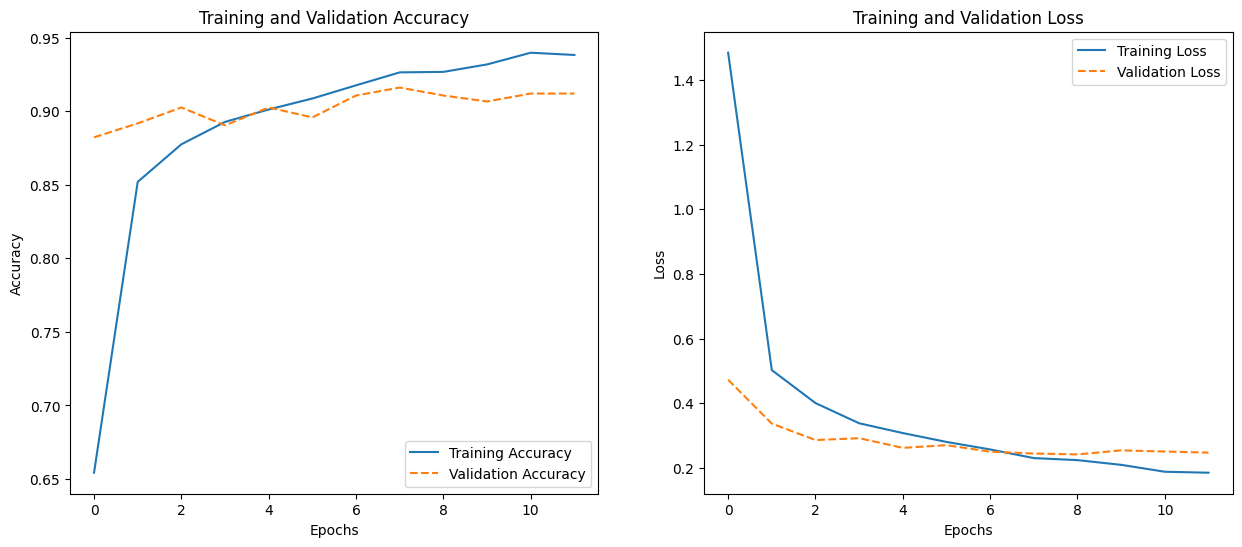

Generating predictions for detailed metrics...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 378ms/step


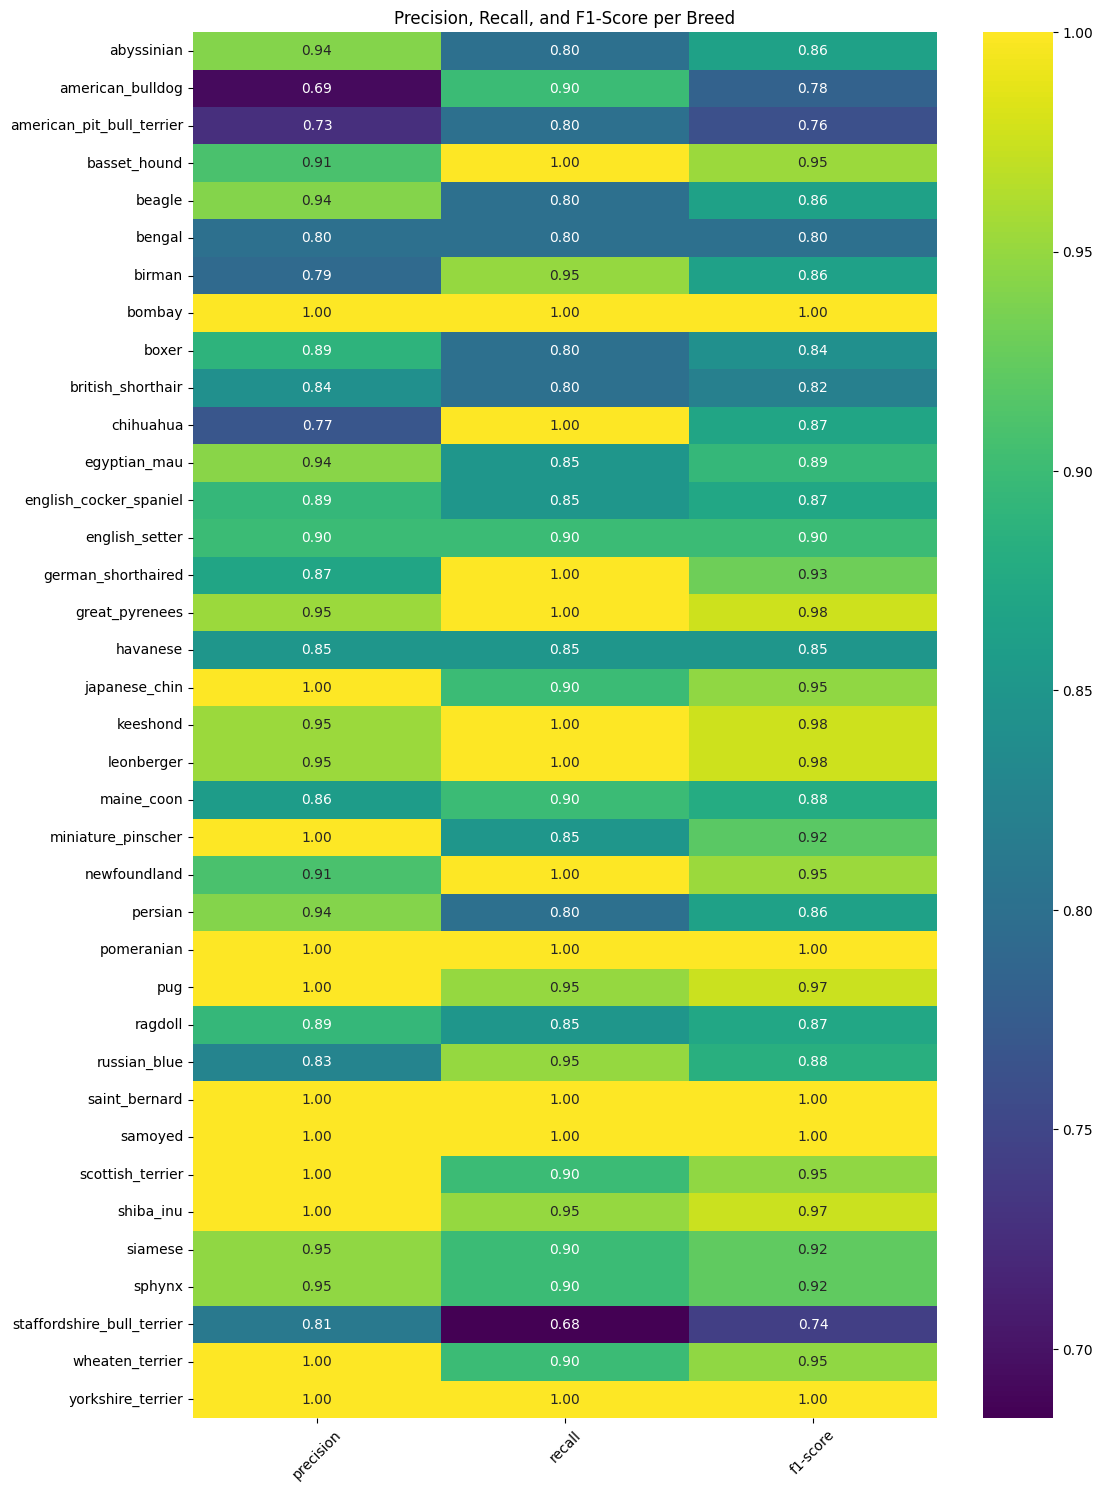


--- Detailed Text Report ---
                            precision    recall  f1-score   support

                abyssinian       0.94      0.80      0.86        20
          american_bulldog       0.69      0.90      0.78        20
 american_pit_bull_terrier       0.73      0.80      0.76        20
              basset_hound       0.91      1.00      0.95        20
                    beagle       0.94      0.80      0.86        20
                    bengal       0.80      0.80      0.80        20
                    birman       0.79      0.95      0.86        20
                    bombay       1.00      1.00      1.00        20
                     boxer       0.89      0.80      0.84        20
         british_shorthair       0.84      0.80      0.82        20
                 chihuahua       0.77      1.00      0.87        20
              egyptian_mau       0.94      0.85      0.89        20
    english_cocker_spaniel       0.89      0.85      0.87        20
            engli

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report

#Standard Accuracy & Loss Curves ---
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(15, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', linestyle='--')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss', linestyle='--')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

#Generate Predictions
print("Generating predictions for detailed metrics...")
# reset() ensures the generator starts from the beginning
test_generator.reset() 
predictions = model.predict(test_generator, steps=len(test_generator))
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

#Classification Report & Heatmap
# output_dict=True lets us get the data as a dictionary so we can plot it
report_dict = classification_report(true_classes, predicted_classes, target_names=class_labels, output_dict=True)

# Convert to Pandas DataFrame for easier plotting
df_report = pd.DataFrame(report_dict).transpose()

# We dropped the 'accuracy', 'macro avg', and 'weighted avg' rows to focus just on the breeds
# We also dropped the 'support' column (number of images) to focus on the scores
plot_df = df_report.drop(['accuracy', 'macro avg', 'weighted avg']).drop(columns=['support'])

# Plotting the Heatmap
plt.figure(figsize=(12, 18))we have 37 breeds
sns.heatmap(plot_df, annot=True, cmap='viridis', fmt='.2f', cbar=True)
plt.title('Precision, Recall, and F1-Score per Breed')
plt.xticks(rotation=45)
plt.show()

# Print the text version as well for reference
print("\n--- Detailed Text Report ---")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))



In [9]:
import json
import os

# 1. Save the Model
# 'h5' is the standard format for Keras models
model.save('animal_breed_model.h5')
print("Model saved successfully as 'animal_breed_model.h5'")

# 2. Save the Class Indices
# We need this to translate the model's numeric output back into breed names later
class_indices = train_generator.class_indices

with open('class_indices.json', 'w') as f:
    json.dump(class_indices, f)

print("Class mapping saved successfully as 'class_indices.json'")

# Verify files were created
print("\nChecking Output Directory:")
print(os.listdir(os.getcwd()))

✅ Model saved successfully as 'animal_breed_model.h5'
✅ Class mapping saved successfully as 'class_indices.json'

Checking Output Directory:
['animal_breed_model.h5', 'class_indices.json', '.virtual_documents']


In [10]:
import os
from IPython.display import FileLink

# 1. Check if files exist in the current directory
print("Checking for files in /kaggle/working/ ...")
files = os.listdir('/kaggle/working')
print(f"Files found: {files}")

# 2. Generate Clickable Download Links
if 'animal_breed_model.h5' in files:
    print("\nClick below to download the Model:")
    display(FileLink(r'animal_breed_model.h5'))
else:
    print("Error: animal_breed_model.h5 not found. Did you run Block 8?")

if 'class_indices.json' in files:
    print("\nClick below to download the Class Indices:")
    display(FileLink(r'class_indices.json'))
else:
    print("Error: class_indices.json not found. Did you run Block 8?")

Checking for files in /kaggle/working/ ...
Files found: ['animal_breed_model.h5', 'class_indices.json', '.virtual_documents']

👇 Click below to download the Model:


/kaggle/working/animal_breed_model.h5


👇 Click below to download the Class Indices:


/kaggle/working/class_indices.json

In [16]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import io
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import json

# Load Resources
# We try to use the model currently in memory. 
# If it's missing (e.g., you restarted), we load it from the saved file.
try:
    model = model
    print("Using model from memory.")
except NameError:
    print("Model not found in memory. Loading 'animal_breed_model.h5'...")
    model = load_model('animal_breed_model.h5')

# Load the class mapping (Number -> Breed Name)
with open('class_indices.json', 'r') as f:
    indices = json.load(f)
# Invert the dictionary: {0: 'abyssinian'} instead of {'abyssinian': 0}
labels = dict((v, k) for k, v in indices.items())


#Prediction Logic
def predict_and_show(uploaded_content):
    # Convert raw bytes to an image
    img = Image.open(io.BytesIO(uploaded_content))
    
    # We keep a copy of the original image for display
    display_img = img.copy()
    
    # Resize to 224x224 for the model
    img = img.resize((224, 224))
    
    # Preprocess
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    
    # Predict
    predictions = model.predict(img_array)
    predicted_index = np.argmax(predictions)
    confidence = np.max(predictions) * 100
    result_breed = labels[predicted_index]
    
    #Show Result
    plt.figure(figsize=(6, 6))
    plt.imshow(display_img)
    plt.axis('off')
    plt.title(f"Predicted: {result_breed.upper()}\nConfidence: {confidence:.2f}%", 
              color='darkblue', fontsize=16, fontweight='bold')
    plt.show()


#Create the Upload Button
uploader = widgets.FileUpload(
    accept='image/*',  # Accept only images
    multiple=False,
    description='Upload Image'
)

output_area = widgets.Output()

# Event Handler
def on_upload_change(change):
    if not uploader.value:
        return
    
    with output_area:
        clear_output()
        print("⏳ Analyzing image...")
        
        # Robust way to get file content (works on different widget versions)
        try:
            # Newer ipywidgets (returns tuple of dicts)
            if isinstance(uploader.value, tuple):
                file_info = uploader.value[0]
            # Older ipywidgets (returns dict)
            else:
                # If it's a dict, we might need to access the first key
                key = list(uploader.value.keys())[0]
                file_info = uploader.value[key]
                
            content = file_info['content']
            predict_and_show(content)
            
        except Exception as e:
            print(f"Error processing image: {e}")
            print("Debug Info:", type(uploader.value))

        # Reset uploader for next use
        uploader.value = ()

uploader.observe(on_upload_change, names='value')

#Display
print("Click the button to upload an image:")
display(uploader)
display(output_area)

✅ Using model from memory.
👇 Click the button to upload an image:


FileUpload(value=(), accept='image/*', description='Upload Image')

Output()